# Intro to CIFAR-10 Classification Project

Computer vision means giving computers the ability to correct classify an image fed into a model. In order to teach computer to classify the images I will use Convulutional Neural Networks built in Keras/Tensorflow. 

In this notebook I will do some discover and exploratory data analysis. This will include ensuring that the correct packages are installed and loading the data. After this notebook, all packages and data loading will be handled by __init__.py.



In order to ensure Keras is running properly, I first use !pip install keras, and see that I alreary have it installed (I am running the jupyter/tensorflow-notebook in docker). 

In [1]:
!pip install keras

    100% |################################| 307kB 3.1MB/s ta 0:00:01
    100% |################################| 256kB 2.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml


In [2]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tarfile

Using TensorFlow backend.


There are two options immediately available to access the CIFAR-10 files. The files are stored in a .tar.gz file on the cs.toronto.edu website. https://www.cs.toronto.edu/~kriz/cifar.html

They are also available as part of the keras toolkit located in keras.datasets.cifar10. In order to get started, I will be using the files stored on the cs.toronto.edu website. 

Below, I unzip the .tar.gz files using Python.

In [2]:
cifar_file = 'cifar-10-python.tar.gz'
tar = tarfile.open(cifar_file, "r:gz")
tar.extractall()
tar.close()

The cs.toronto.edu website includes a function to open the batched files. Each batch includes 10,000 rows, with 6 batches for 60,000 rows total. The first 5 are used as train, and the 6th batch is reserved for test.

There are 3072 features or columns for each row, with 1024 features for each of the red, green, and blue color channels.

The complete file is 60,000 x 3072. 

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
for n in range(1,6):
    cifar_dict = unpickle('cifar-10-batches-py/data_batch_'+str(n))
    #build a single structure containing the data matrix X, and the target column vector Y
    if n == 1:
        X_train = np.array(cifar_dict[b'data'])
        y_train = np.array(cifar_dict[b'labels'])
    else:
        X_train = np.concatenate([X_train, cifar_dict[b'data']], axis=0)
        y_train = np.concatenate([y_train, cifar_dict[b'labels']], axis=0)
X_train.shape, y_train.shape

((50000, 3072), (50000,))

In [5]:
cifar_dict = unpickle('cifar-10-batches-py/test_batch')
X_test = np.array(cifar_dict[b'data'])
y_test = np.array(cifar_dict[b'labels'])

X_test.shape, y_test.shape

((10000, 3072), (10000,))

The class names are stored in another file called batches.meta. They are encoded in bytes format, so I take some time to reformat them as strings and store them in a list for ease of access later. 

This project involves classifying 32x32 images to one of 10 image classifications. The ten classifications are listed below. 

|#| Classifications |
|---| ------------- |
|0| airplane			|							
|1| automobile		|								
|2| bird				|						
|3| cat				|						
|4| deer				|						
|5| dog				|						
|6| frog				|						
|7| horse				|						
|8| ship				|						
|9| truck|

In [6]:
class_names_dict = unpickle('cifar-10-batches-py/batches.meta')

In [7]:
readable = lambda nam: str(nam)[2:-1]

class_names_list = []
for name in class_names_dict[b'label_names']:
    class_names_list.append(str(name)[2:-1])
    
class_names_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
X_train.dtype, y_train.dtype, X_test.dtype, y_train.dtype

(dtype('uint8'), dtype('int64'), dtype('uint8'), dtype('int64'))

In [9]:
y_train[0:5]

array([6, 9, 9, 4, 1])

#### Data Exploration

To explore what the different labels mean, I would like to see a sample of one of each label, and return a list of unique labels for reference later. 

In [10]:
def show_unique_images(images, labels, class_names=class_names_list):
    unique_labels = []
    unique_indices = []
    
    fig = plt.figure(figsize=(25,10))
    
    n = 0
    for i in range(len(labels)):
        if labels[i] not in unique_labels:
            image = images[i].reshape(3,32,32).transpose(1,2,0)
            plt.subplot(2,5,n+1)
            n += 1
            plt.imshow(image, interpolation="nearest")
            plt.title(class_names[labels[i]])
            unique_labels.append(labels[i])
            unique_indices.append(i)
    plt.show()
    
    return unique_indices

In [11]:
def show_images(images, labels, indices, class_names=class_names_list):
    fig = plt.figure(figsize=(25,10))
    n = 0
    for i in indices:
        image = images[i].reshape(3,32,32).transpose(1,2,0)
        plt.subplot(2,5,n+1)
        n += 1
        plt.imshow(image)
        plt.title(class_names[labels[i]])
    plt.show()
    
    return None

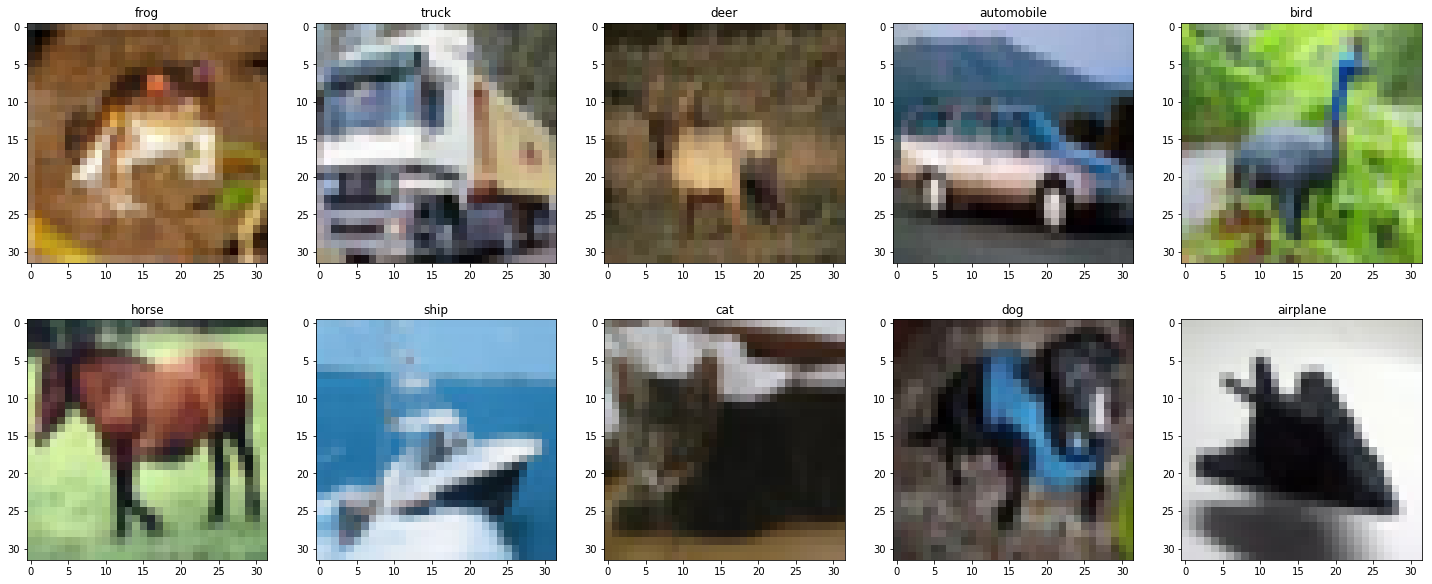

In [12]:
unique_indices = show_unique_images(X_train, y_train)

In [13]:
unique_indices

[0, 1, 3, 4, 6, 7, 8, 9, 27, 29]

In order to load the images using pyplots's imshow() method, I had to play around with the shape and orientation of the data. The raw data comes as a single row of rbg values. In order to show them properly, they must be reshaped to 32,32,3. In order to do so, they first need to be reshaped to 3,32,32, then transposed to 32,32,3. 

Above the ten types of images can be seen. The y target values are numerical from 0 to 9, and coorespond to the list of classifications loaded earlier. 

To get another set of unique images, I will send the X array through the function again, this time with the 10 identified unique images indices removed. 

In [14]:
X_train.shape

(50000, 3072)

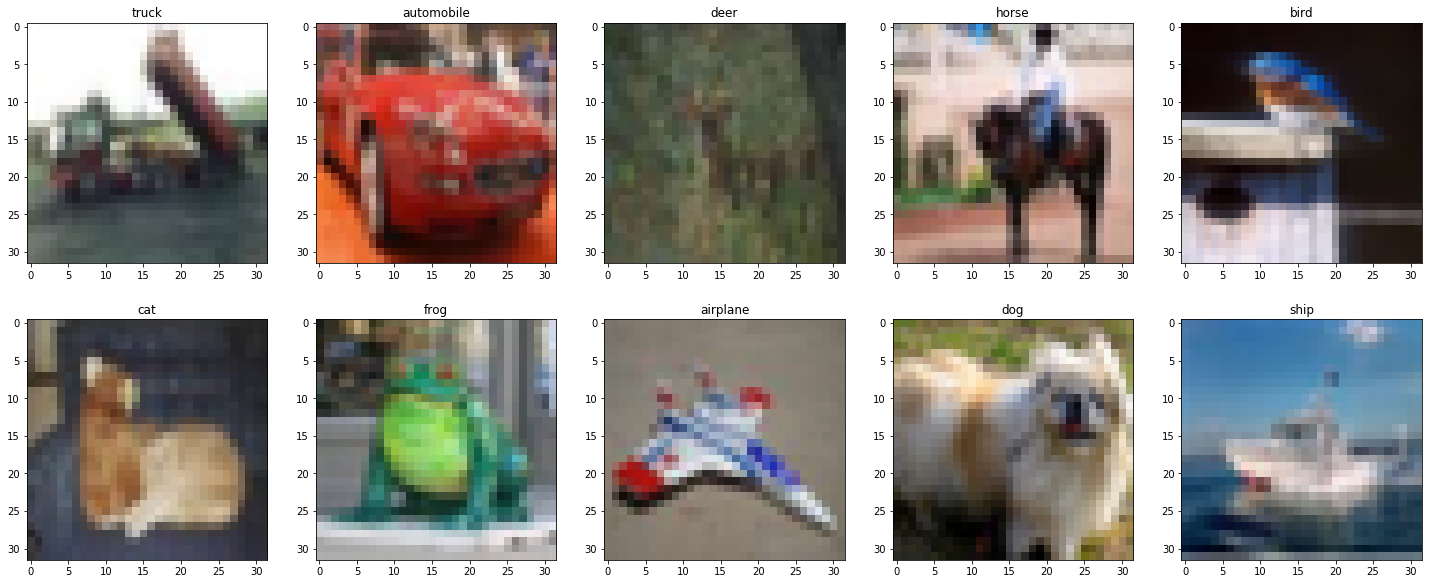

[0, 1, 2, 3, 5, 9, 11, 20, 30, 52]

In [15]:
c = [x for x in range(50000) if x not in unique_indices]
show_unique_images(X_train[c], y_train[c])

What happens if a single color channel is replaced entirely by zeros? 

In [28]:
def drop_color_channel(images, labels, indices, drop_color):
    new_images = []
    
    for image in images[indices]:
        #Drop red
        if drop_color == 0:
            new_images.append(np.concatenate([np.zeros(1024), image[1024:]], axis=0))
        #Drop green
        if drop_color == 1:
            new_images.append(np.concatenate([image[:1024], np.zeros(1024), image[2048:]], axis=0))
        #Drop blue
        if drop_color == 2:
            new_images.append(np.concatenate([image[:2048], np.zeros(1024)], axis=0))

    show_images(new_images, labels[indices], list(range(len(new_images))))
    
    return None

In [29]:
y_train[unique_indices]

array([6, 9, 4, 1, 2, 7, 8, 3, 5, 0])

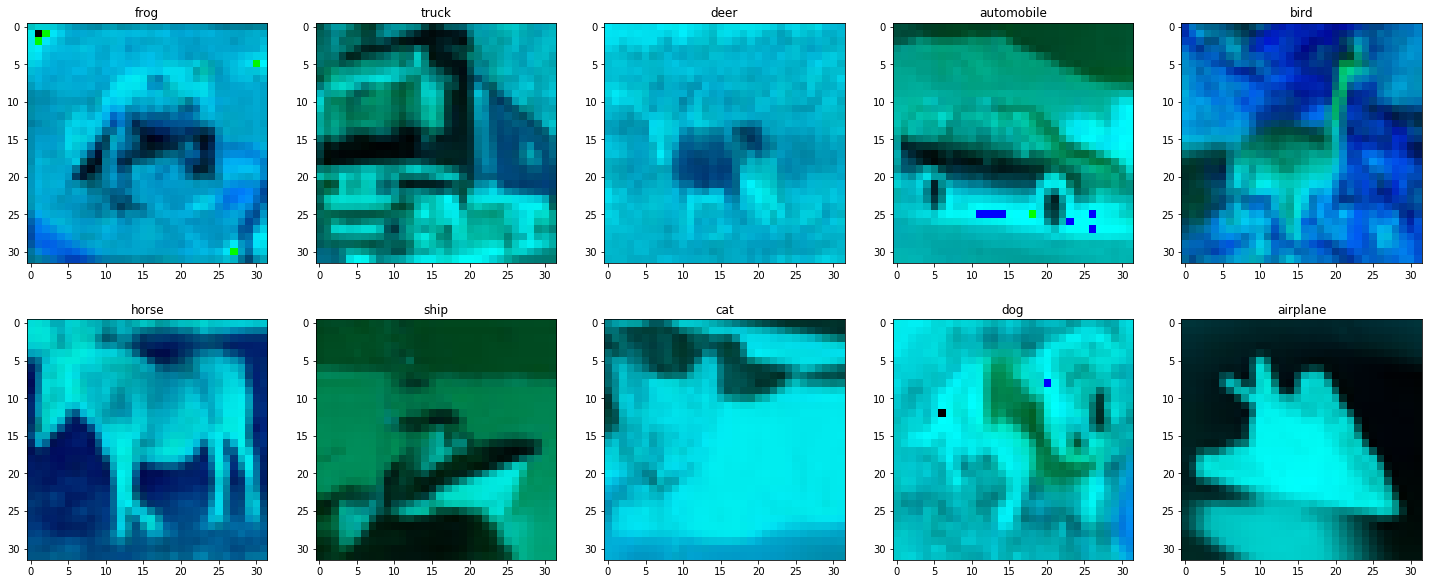

In [30]:
#Drop the red channel by replacing it with zeros
drop_color_channel(X_train, y_train, unique_indices, 0)

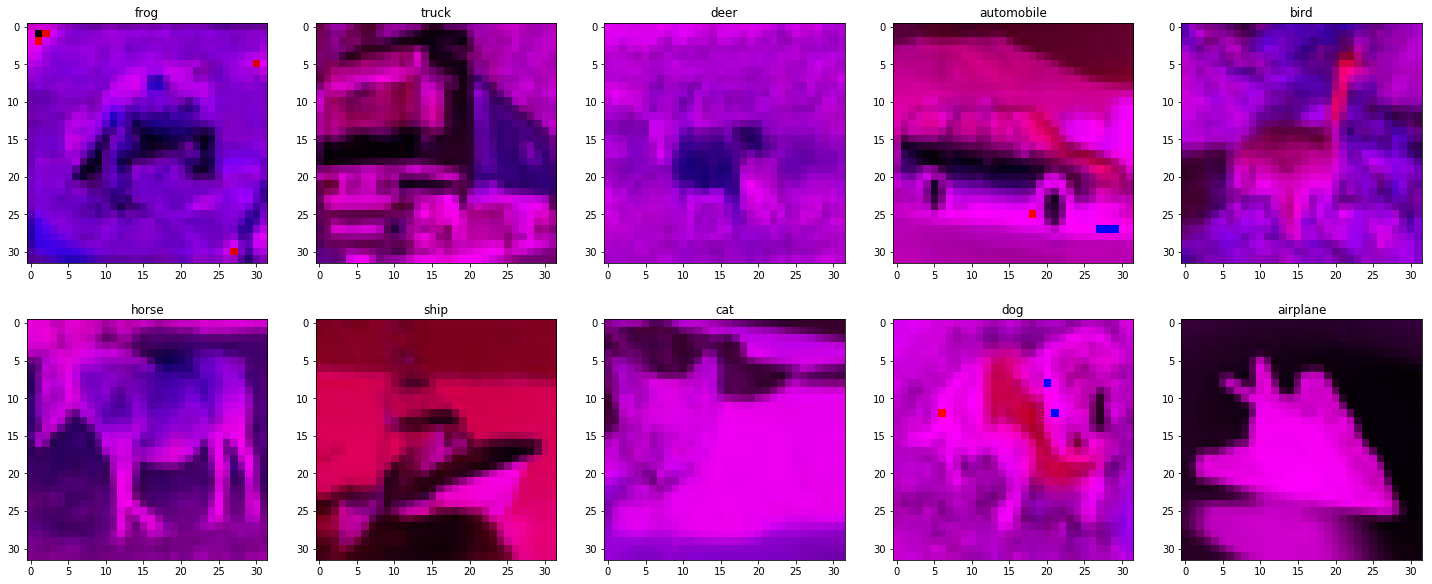

In [31]:
#drop the green channel by replacing it with zeros
drop_color_channel(X_train, y_train, unique_indices, 1)

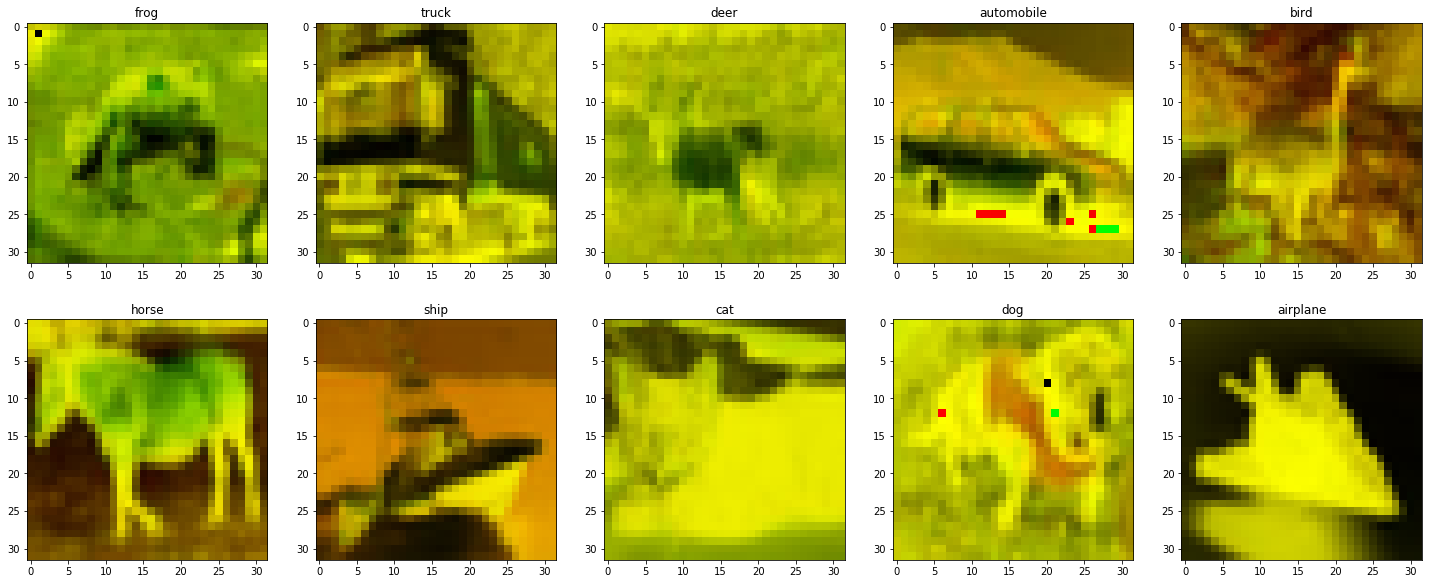

In [32]:
#Drop the blue channel by replacing it with zeros
drop_color_channel(X_train, y_train, unique_indices, 2)

How are the colors represented by a histogram? What would histograms look like for each of the three color channels for these images? 

In [33]:
def display_color_hists(images, labels, indices, class_names=class_names_list):
    fig = plt.figure(figsize=(15,50))
    n = 0
    for i in indices:
        plt.subplot(10,3,n+1)
        plt.hist(images[i][:1024])
        plt.title("red: " + class_names[labels[i]])
        n += 1
        
        plt.subplot(10,3,n+1)
        plt.hist(images[i][1024:2048])
        plt.title("green: " + class_names[labels[i]])
        n += 1
        
        plt.subplot(10,3,n+1)
        plt.hist(images[i][2048:])
        plt.title("blue: " + class_names[labels[i]])
        n += 1
    plt.show()
    
    return None

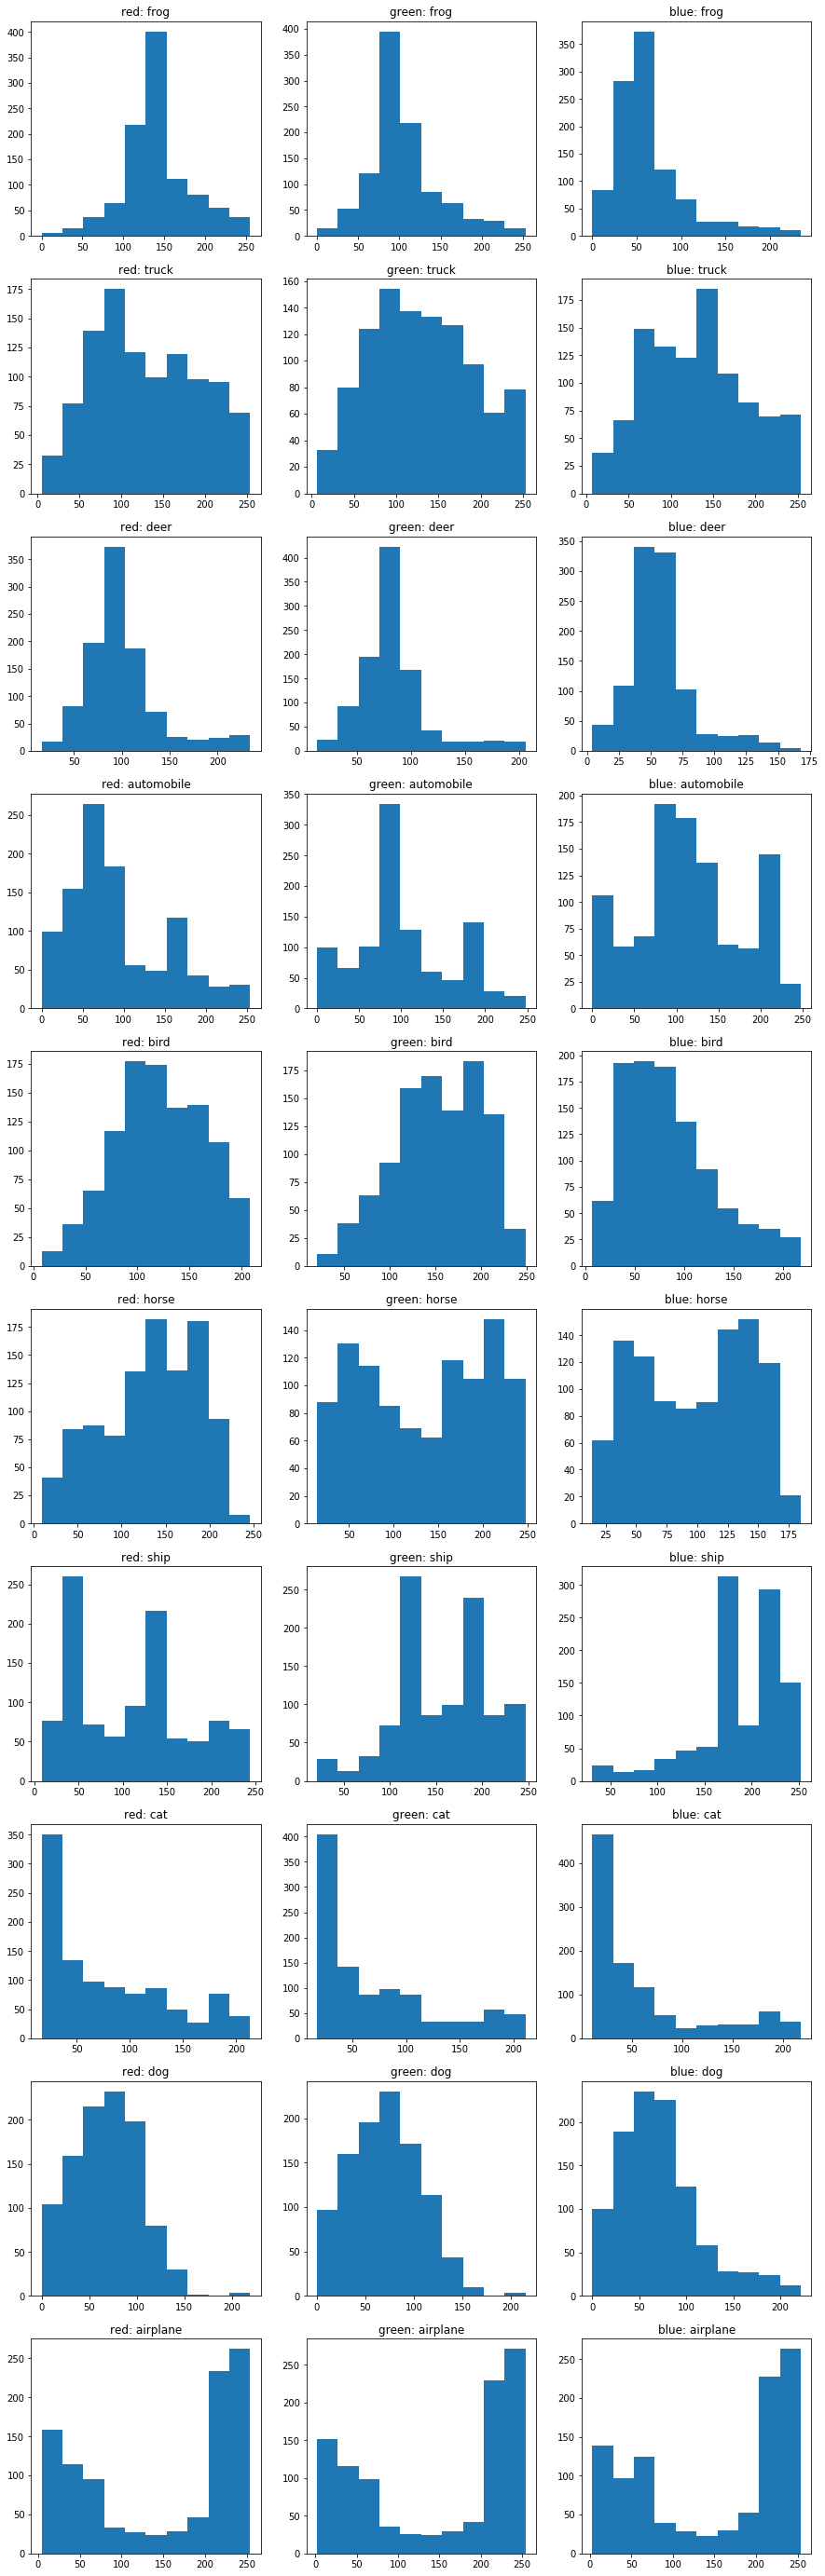

In [34]:
display_color_hists(X_train, y_train, unique_indices)

#### Class Balance

The readme located at cs.toronto.edu states that there is an even distribution of all classes, with 5000 of each in the 5 training sets, and 1000 images of each class in the test batch. The classes are randomly distributed between the training batch files, but since I am working on the training group as a whole, not the individual batches, this information should be irrelevant for me. 

Below I confirm that the classes are indeed evenly balanced. 

In [35]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [36]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Indeed, each of the ten classes has 5,000 samples in the training batch and 1,000 samples in the test batch. 